# Graph Convolutional Network

My attempt at building a simple 2-layer Graph Convolution Neural Network for graph classification with Pytorch.

Utilises the definitions and architecture outlined in _Kipf & Welling, [Semi-Supervised Classification with Graph Convolutional Networks](http://arxiv.org/abs/1609.02907) (ICLR 2017)_.

In [0]:
!pip install dgl

In [0]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

%matplotlib inline

## Data

The dataset we use is a synthetic dataset consisting of 8 types of graphs with different graph structures. The aim is to build a GCN to classify the graphs into their respective types.

The dataset is generated without any node attributes, so a random vector of a fixed size is added as each node's attribute so graph convolution can be done.

In [0]:
def generate_dataset(size, attr_vector_length=2):
    """
    Method to generate dataset from DGL's MiniGCDataset.

    Params:
        size: No. of entries to generate
        attr_vector_length (optional): Length of node attribute vector. Default 2.
    """
    gcdataset = MiniGCDataset(size,10,20)
    dataset = []
    for i in np.arange(size):
        graph, label = gcdataset[i]
        label = torch.Tensor([label]).long() # tensor([class])
        graph = graph.to_networkx()
        node_attrs = {i: list(torch.randn(attr_vector_length)) for i in np.arange(graph.number_of_nodes())}
        nx.set_node_attributes(graph, node_attrs, 'name') # add random attr_vector_length-length vector as node attribute for all nodes (attribute 'name')
        dataset.append( (graph, label) )
    
    return dataset

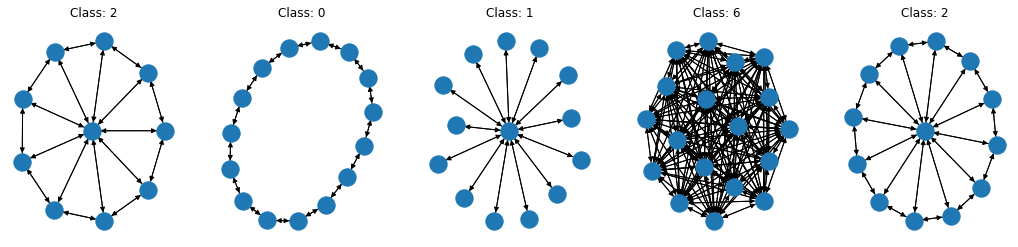

In [4]:
N_classes = 8
TRAIN_SIZE = 320
TEST_SIZE = 80

train = generate_dataset(TRAIN_SIZE)
test = generate_dataset(TEST_SIZE)
    
# show samples from dataset
plt.figure(figsize=(18,4))
for i, g in enumerate(np.random.randint(0, TRAIN_SIZE, 5)):
    graph, label = train[g]
    plt.subplot(1,5,i+1)
    nx.draw(graph)
    plt.title('Class: {}'.format(int(label.squeeze())));

## Graph convolution

A graph convolution is defined as follows (eqn. 8 in _Kipf & Welling_). 

For a signal $X \in \mathbb{R}^{N \times C}$ with $N$ nodes and $C$ input channels, and $F$ filters or feature maps:
$$ Z = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} X \Theta ,$$

where:
* $Z \in \mathbb{R}^{N \times F}$ is the convolved signal matrix
* $\Theta \in \mathbb{R}^{C \times F}$ is a matrix of filter parameters
* $\tilde{A} = A + I_N$ is the adjacency matrix A with added self-connections
* $\tilde{D} = \sum_j \tilde{A}_{ij}$ is the degree matrix of the new adjacency matrix

Here a _renormalisation trick_ is performed, such that the rescaled, normalised graph Laplacian with self-loops is expressed by $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$.

In [0]:
def get_feature_matrix(g):
    """
    Method to gather a graph's node features as matrix.

    Params:
        g: networkx graph
    Returns:
        X: A tensor of size N x C, where N = no. of nodes & C = no. of channels.
    """
    return torch.Tensor(list(nx.get_node_attributes(g, 'name').values()))

#### Example graph convolution

In [6]:
g = train[0][0]
N = g.number_of_nodes()
X = get_feature_matrix(g)

ϴ = nn.Linear(in_features=2, out_features=3)
A = torch.Tensor( nx.adjacency_matrix(g).todense() ) # A = dense adj. matrix as Tensor

A_tilde = A + torch.eye(N) # add self-connections
D_tilde = torch.sum(A_tilde, 1) # degree matrix of A_tilde
D_tilde_half = (D_tilde + 1e-5) ** (-0.5)
L_tilde = D_tilde_half * A * D_tilde_half # rescaled normalised graph Laplacian

Z = ϴ(torch.mm(L_tilde, X))
Z

tensor([[ 0.1285,  0.7630,  0.3671],
        [-0.0329,  0.7000,  0.4678],
        [-0.2747,  0.4365,  0.4258],
        [ 0.0235,  0.5104,  0.1913],
        [ 0.7470,  0.8098, -0.2406],
        [ 0.4883,  0.6576, -0.1377],
        [ 0.5914,  0.7692, -0.1206],
        [ 0.2185,  0.5430,  0.0201],
        [ 0.1972,  0.5666,  0.0696],
        [ 0.0798,  0.3625, -0.0375],
        [-0.0289,  0.3442,  0.0579],
        [ 0.3584,  0.7133,  0.0647],
        [ 0.1409,  0.7204,  0.3053],
        [ 0.0606,  0.7285,  0.4004],
        [ 0.1949,  0.7515,  0.2831]], grad_fn=<AddmmBackward>)

## GCN Layer

In [0]:
class GCNLayer(nn.Module):
    """
    Torch Module for a single graph convolution.
    """

    def __init__(self, C, F):
        """
        Params:
            C: No. of channels in input signal. i.e. length of node feature vector.
            F: No. of filters/ feature banks.
        """
        super(GCNLayer, self).__init__() #idk what this does?
        self.ϴ = nn.Linear(in_features=C, out_features=F)
        
    def forward(self, g, X):
        """
        Params:
            g: input graph (networkx)
            X: feature matrix / signal from prev layer. Use get_feature_matrix(g) for first network layer.
        """
        N = g.number_of_nodes()
        A = torch.Tensor( nx.adjacency_matrix(g).todense() ) # A = dense adj. matrix as Tensor

        A_tilde = A + torch.eye(N) # add self-connections
        D_tilde = torch.sum(A_tilde, 1) # degree matrix of A_tilde
        D_tilde_half = (D_tilde + 1e-5) ** (-0.5)
        L_tilde = D_tilde_half * A * D_tilde_half # rescaled normalised graph Laplacian

        Z = self.ϴ(torch.mm(L_tilde, X))
        return Z

#### Example GCN layer

In [8]:
gcn = GCNLayer(C=2, F=5)
gcn(g, get_feature_matrix(g))

tensor([[ 0.8439,  0.7297,  0.8596,  0.7005,  0.4887],
        [ 0.9879,  0.6957,  0.8485,  0.8652,  0.3159],
        [ 0.9275,  0.5034,  0.5719,  0.8090,  0.2482],
        [ 0.5923,  0.5306,  0.5271,  0.4287,  0.6153],
        [-0.0249,  0.6971,  0.6031, -0.2784,  1.3699],
        [ 0.1221,  0.5998,  0.5065, -0.1065,  1.1511],
        [ 0.1466,  0.6811,  0.6232, -0.0838,  1.1808],
        [ 0.3475,  0.5352,  0.4736,  0.1521,  0.8729],
        [ 0.4184,  0.5574,  0.5211,  0.2308,  0.8142],
        [ 0.2650,  0.4004,  0.2698,  0.0673,  0.8672],
        [ 0.4013,  0.3977,  0.2995,  0.2214,  0.7236],
        [ 0.4114,  0.6614,  0.6611,  0.2165,  0.8920],
        [ 0.7555,  0.6926,  0.7876,  0.6030,  0.5555],
        [ 0.8915,  0.7087,  0.8426,  0.7555,  0.4250],
        [ 0.7238,  0.7124,  0.8068,  0.5660,  0.6018]],
       grad_fn=<AddmmBackward>)

## Network for classsification
_Kipf and Welling_ use a network two GCN layers followed by a linear layer for classification. I use the same architecture here. A mean reduction operation is applied on the output of the two GCN layers, row-wise. Finally, _softmax_ is applied to the classification layer's output. 

Thus the network can be expressed as the following:
$$Z = \text{softmax}\big( \tilde{L} \space \text{ReLU} \big( \tilde{L} X \Theta^{(0)} \big) \space \Theta^{(1)} \big),$$

where $\tilde{L} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} $ and $\Theta^{(i)}$ is the weight matrix for the $i^\text{th}$ layer.

In [0]:
class Classifier(nn.Module):
    """
    2 layer Graph CNN for graph classification
    """

    def __init__(self, c, f_in, f_hidden, n_classes):
        """
        Params:
            c: No. of channels. (Length of node feature vector)
            f_in: No. of filters in input layer
            f_hidden: No. of filters in hidden layer
            n_classes: No. of output classes
        """
        super(Classifier, self).__init__()

        self.gcn1 = GCNLayer(C=c, F=f_in)
        self.gcn2 = GCNLayer(C=f_in, F=f_hidden)

        self.classify = nn.Linear(f_hidden, n_classes)


    def forward(self, g):
        """
        Params:
            g: input graph (networkx)
        Returns:
            Z: classifier output
        """
        Z = F.relu(self.gcn1(g, get_feature_matrix(g)))
        Z = F.relu(self.gcn2(g, Z))
        Z = self.classify(Z.mean(axis=0)) # mean reduce, row-wise
        Z = F.softmax(Z, dim=0)
        return Z

#### Network graph

In [10]:
model = Classifier(c=2, f_in=7, f_hidden=5, n_classes=N_classes)
model

Classifier(
  (gcn1): GCNLayer(
    (Θ): Linear(in_features=2, out_features=7, bias=True)
  )
  (gcn2): GCNLayer(
    (Θ): Linear(in_features=7, out_features=5, bias=True)
  )
  (classify): Linear(in_features=5, out_features=8, bias=True)
)

#### Example prediction using network

In [11]:
prediction = model(g)
prediction

tensor([0.0946, 0.1550, 0.0859, 0.0795, 0.1626, 0.1476, 0.1571, 0.1177],
       grad_fn=<SoftmaxBackward>)

## Training

Train the network on every training example, using the Adam optimiser with Cross-Entropy Loss.

Training: 100%|██████████| 320/320 [04:27<00:00,  1.20it/s]


Text(0, 0.5, 'Cross-Entropy Loss')

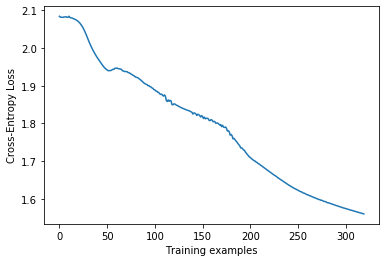

In [13]:
model = Classifier(c=2, f_in=7, f_hidden=5, n_classes=N_classes)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

epoch_losses = []
for epoch in tqdm(range(TRAIN_SIZE), desc='Training'):
    epoch_loss = 0
    for iter, (graph, label) in enumerate(train):
        prediction = model(graph)
        prediction = prediction.unsqueeze(0) # add batch dimension for loss to work
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()

    epoch_loss /= (iter + 1)
    # print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.xlabel('Training examples')
plt.ylabel('Cross-Entropy Loss')

#### Testing

In [40]:
model.eval()
test_pred = []
targets = []

# get model predictions for test data
for g, target in test:
    test_pred.append( model(g).argmax() )
    targets.append(target.squeeze())

print(accuracy_score(targets, test_pred))

0.725
